In [6]:
#uncomment to clean up the variables
#%reset -f

In [7]:
#make sure you installed the pyetc and is in the correct folder
from pyetc_dev import *

#install the other packages needed
import os
import matplotlib.pyplot as plt
from astropy import constants
import skycalc_ipy
from mpdaf.obj import Spectrum

import warnings
warnings.filterwarnings('ignore')

In [8]:
# convenient function for the range check
def check_range(arr, M_min, M_max):
    
    if arr[0] > M_min:
        print('Trace starts after the first pixel!')
    if arr[-1] < M_max:
        print('Trace ends before the last pixel!')

def check_line(cen, fwhm, M_min, M_max):
    if cen > M_max:
        print('Line outside the last pixel!')
    elif cen + fwhm > M_max:
        print('Line near the last pixel!')
    if cen < M_min:
        print('Line outside the first pixel!')
    elif cen - fwhm < M_min:
        print('Line near the first pixel!')

# set up the WST container
obj_WST = WST(log = 'DEBUG', skip_dataload = False)

# set up the spectral calibration 
phot_system = PhotometricSystem()
sed_models = SEDModels()
filter_manager = FilterManager(phot_system)

# build the observation
def build_obs_full(container_wst, fo):
    
    insfam = getattr(container_wst, fo["INS"]) 
    CONF = insfam[fo["CH"]]
    
    #work-around for the definition of the spectral type for the cont/line:
    
    if fo["SPEC"] == 'line':
        dummy_type = 'line'
    elif fo["SPEC"] in ('template', 'pl', 'bb'):
        dummy_type = 'cont'
        
    obs = dict(
    moon=fo["MOON"],
    airmass = fo["AM"],
    seeing = fo["SEE"],
    ndit = fo["NDIT"],
    dit = fo["DIT"],
    spec_type = dummy_type,
    spec_range_type = fo["SPEC_RANGE"],
    spec_range_kfwhm = fo["SPEC_KFWHM"],
    spec_range_hsize_spectels = fo["SPEC_HSIZE"],  
    ima_type = fo["OBJ"],
    ima_area = fo["IMA_AREA"],
    ima_aperture_type = fo["IMA_RANGE"],
    ima_kfwhm = fo["IMA_KFWHM"],
    ima_aperture_hsize_spaxels = fo["IMA_HSIZE"],
    skycalc = fo["SKYCALC"]
)
    
# compute the sky here if necessary
    if fo["SKYCALC"]:
        obs["skyemi_lsf"], obs["skyabs"], obs["skyemi"]  = get_sky2(container_wst, fo)
    
    container_wst.set_obs(obs)
    
    #we compute the value here
    spec_input, spec, spec_conv =  get_spec2(container_wst, fo)
    
    #here the mpdaf image only in the resolved case
    ima = None
    if fo['OBJ'] == 'resolved':
        dima = {
            'type': fo["IMA"],
            'fwhm': fo["IMA_FWHM"], 
            'beta': fo["IMA_BETA"],
            'n': fo["IMA_N"],
            'reff': fo["IMA_REFF"],
            'ell': fo["IMA_ELL"],
            'kfwhm': fo["IMA_KFWHM"],
            'kreff': fo["IMA_KREFF"],
        }
        ima = container_wst.get_ima(CONF, dima)
        
    old_flux = 1
        
    if (fo["OPT_SPEC"]) & (fo["SPEC_RANGE"] == "adaptative") & (dummy_type == "line"):
        container_wst.optimum_spectral_range(CONF, old_flux, ima, spec)

    if (fo["OPT_IMA"]) & (fo["IMA_RANGE"] == "circular_adaptative") & (fo["OBJ"] in ('ps', 'resolved')):
        A = CONF['lbda1']
        B = CONF['lbda2']
        f = fo['FRAC_SPEC_MEAN_OPT_IMAGE']

        delta = (1 - f) / 2
        AA = A + delta * (B - A)
        BB = B - delta * (B - A)
        
        #done with the mean SNR in a range defined around the center by the factor f
        container_wst.optimum_circular_aperture(CONF, old_flux, ima, spec, lrange=[AA,BB])
    
    return CONF, obs, spec_conv, spec, spec_input, obs["skyemi_lsf"], obs["skyemi"], obs["skyabs"], CONF['instrans']

# spec computation 
def get_spec2(container_wst, fo, oversamp = 1):

    insfam = getattr(container_wst, fo["INS"]) 
    CONF = insfam[fo["CH"]]
    
    lstep = CONF['instrans'].get_step()
    l1,l2 = CONF['instrans'].get_start(), CONF['instrans'].get_end()
        
    if fo['SPEC'] == 'template':
        name, DEFAULT_WAVE, flux =  sed_models.template(f"{fo['TEMP_NAME']}.dat")
        redshift = fo['Z']
        band = fo['FIL']
        mag = fo['MAG']
        syst = fo['SYS']

        mag, syst = phot_system.auto_conversion(mag, band, syst)

        #redshift correction
        DEFAULT_WAVE *= (1+redshift)
        
        #check if it's all inside the range of the instrumental setup
        check_range(DEFAULT_WAVE, l1, l2)

        _, _, K = filter_manager.apply_filter(DEFAULT_WAVE, flux, band, mag, syst)

    elif fo['SPEC'] == 'bb':
        DEFAULT_WAVE = np.linspace(100,30000,10000)
        tmp = fo['TEMP']
        band = fo['FIL']
        mag = fo['MAG']
        syst = fo['SYS']
    
        flux =  sed_models.blackbody(DEFAULT_WAVE,tmp)

        mag, syst = phot_system.auto_conversion(mag, band, syst)

        _, _, K = filter_manager.apply_filter(DEFAULT_WAVE, flux, band, mag, syst)
    
    
    elif fo['SPEC'] == 'pl':
        DEFAULT_WAVE = np.linspace(100,30000,10000)
        indpl = fo['INDEX']
        band = fo['FIL']
        mag = fo['MAG']
        syst = fo['SYS']
        
        flux =  sed_models.powerlaw(DEFAULT_WAVE, indpl)

        mag, syst = phot_system.auto_conversion(mag, band, syst)

        _, _, K = filter_manager.apply_filter(DEFAULT_WAVE, flux, band, mag, syst)
    
    elif fo['SPEC'] == 'line':
        DEFAULT_WAVE = np.linspace(100,30000,10000)
        
        center = fo['INDEX']
        band = fo['FIL']
        mag = fo['MAG']
        syst = fo['SYS']
    
        center = fo['WAVE_CENTER']
        fwhm = fo['WAVE_FWHM']
        
        check_line(center, fwhm, l1, l2)

        tot_flux = fo['FLUX']

        flux = sed_models.gaussian_line(DEFAULT_WAVE, center, tot_flux, fwhm)
    
        K = 1
        oversamp = 10
        
    # put wave and flux*K in a MPDAF object here
    spec_raw = Spectrum(data=flux*K, wave=WaveCoord(cdelt=DEFAULT_WAVE[1]-DEFAULT_WAVE[0], crval=DEFAULT_WAVE[0]))
    
    # resample
    rspec = spec_raw.resample(lstep, start=l1)
    rspec = rspec.subspec(lmin=l1, lmax=l2)
    spec_cut = rspec
    
    spec_cut.oversamp = oversamp
    
    spec_cut_lsf = spec_cut.filter(width=CONF['lsfpix'])
    
    return spec_raw, spec_cut, spec_cut_lsf

# sky computation
def sun_moon_sep(fli):
    if not 0 <= fli <= 1:
        raise ValueError("FLI must be between 0 and 1.")
    theta_rad = np.arccos(1 - 2 * fli)  # result in radians
    theta_deg = np.degrees(theta_rad)  # convert to degrees
    return theta_deg

def compute_sky2(container_wst, fo):
    insfam = getattr(container_wst, fo["INS"]) 
    CONF = insfam[fo["CH"]]
    
    mss = sun_moon_sep(fo['FLI'])
    airmass = fo['AM']
    pwv = fo['PWV']
    allowed_pwv = [0.05, 0.01, 0.25, 0.5, 1.0, 1.5, 2.5, 3.5, 5.0, 7.5, 10.0, 20.0, 30.0]
    closest_value = min(allowed_pwv, key=lambda v: abs(v - pwv))

    if pwv not in allowed_pwv:
        print(f"PWV value not allowed, assigned the closest one: {pwv} → {closest_value}")
        pwv = closest_value
    
    skycalc = skycalc_ipy.SkyCalc()

    skycalc["msolflux"] = 130
    skycalc['observatory'] = 'paranal'
    skycalc['airmass'] = airmass
    skycalc['pwv'] = pwv
    skycalc['moon_sun_sep'] = mss
    
    skycalc['wmin'] = CONF['lbda1']/10
    skycalc['wmax'] = CONF['lbda2']/10
    skycalc['wdelta'] = CONF['dlbda']/10
    
    skycalc['wgrid_mode'] = 'fixed_wavelength_step'
    skycalc['wres'] = 20000 #not sure it is used somewhere, for now I keep it

    tbl = skycalc.get_sky_spectrum(return_type="tab-ext")
    
    if abs(tbl['lam'][0]*10 - CONF['lbda1'])>CONF['dlbda'] or \
       abs(tbl['lam'][-1]*10 - CONF['lbda2'])>CONF['dlbda'] or \
       abs(tbl['lam'][1]- tbl['lam'][0])*10 - CONF['dlbda']>0.01:
        raise ValueError(f'Incompatible bounds between called configuration and setup')
    
    d = dict()
    d['emi_orig'] = Spectrum(data = tbl['flux'], wave = CONF['wave'])
    d['emi'] = d['emi_orig'].filter(width=CONF['lsfpix'])
    d['abs'] = Spectrum(data = tbl['trans'], wave = CONF['wave'])
    
    return d, tbl

# to return the emission and transmission of the sky
def get_sky2(container_wst, fo):
    d, _ = compute_sky2(container_wst, fo)
    return d['emi'], d['abs'], d['emi_orig']

In [9]:
#this to see the available filters Vega
filter_manager.phot_system.filters_vega

['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']

In [10]:
#this to see the available filters AB
filter_manager.phot_system.filters_AB

['uSDSS',
 'gSDSS',
 'rSDSS',
 'iSDSS',
 'zSDSS',
 'uLSST',
 'gLSST',
 'rLSST',
 'iLSST',
 'zLSST']

In [11]:
#this to see all the available templates
sed_models.eso_spectra_files.keys()

dict_keys(['Pickles_O5V', 'Kinney_starb5', 'Kinney_starb4', 'Kinney_sa', 'Kinney_starb6', 'Pickles_O9V', 'Kinney_sb', 'Galev_E', 'Pickles_B2IV', 'Kinney_s0', 'Kinney_starb3', 'Kinney_starb2', 'Pickles_A0III', 'Kinney_starb1', 'Pickles_A0V', 'Pickles_K2V', 'Kurucz_B8V', 'Pickles_G0V', 'Pickles_M2V', 'Kurucz_G2V', 'Pickles_B9III', 'Kurucz_A1V', 'Pickles_B9V', 'Kurucz_B1V', 'Kurucz_F0V', 'Kinney_ell', 'Pickles_K7V', 'qso-interp'])

### DIctionary notes

for the 1D spectrum you need only the parameters listed between `INS` and `WAVE_FWHM`, you can leave the other parameters as they are now, in particular:


- (1) `INS`: is the *instrument*, can be `ifs`, `moshr` (high resolution), `moslr` (low resolution).


- (2) `CH`: is the *channel*, you can see the possibilities typing `obj_WST.INS['channels]` (e.g. `obj_WST.ifs['channels']` will print `['blue', 'red']` which are the two channels of the ifs, so the two possibilites in the dictionary if you select `"INS": "ifs"` will be  `blue` or `red`.


- (3) Sky configuration computed the from the ESO Skycalc on the fly using `PWV` (which can take only values from the following array: `[0.05, 0.01, 0.25, 0.5, 1.0, 1.5, 2.5, 3.5, 5.0, 7.5, 10.0, 20.0, 30.0]`), seeing `SEE`, moon illumination `FLI` (between 0 and 1) and the same airmass `AM`


- (4) `SPEC` determines the type of spectrum you can have can be: blackbody (`bb`), powerlaw (`pl`), template (`template`) and emission line (`line`), for the first three the magnitude (`MAG`), system (`SYS`) and filter (`FIL`) are used to calibrate the spectrum, for the `line` the `FLUX` is used to calibrate it, then
    - (4.1) for the `bb` the `TEMP` parameter is used (in Kelvin)
    - (4.2) for the `pl` the `INDEX` parameter is used
    - (4.3) for the `template` the `TEMP_NAME` is taken (look at `sed_models.eso_spectra_files.keys()` for available names), as well as the redshift `Z`
    - (4.4) for line the `WAVE_CENTER` and `WAVE_FWHM` are needed (both in Angstrom)


In [12]:

full_obs = {
    "INS": "ifs",
    "CH": "red",
    
    "PWV": 3.5,
    "FLI": 0.5,
    "SEE": 1.0,
    "AM": 1.0,
    
    
    "SPEC": 'template',
    
    "MAG": 20,
    "SYS": 'Vega',
    "FIL": 'R',
    "FLUX": 50e-16,
    
    "TEMP_NAME": 'Pickles_A0V',  
    "Z": 1,
    "TEMP": 5000.,
    "INDEX": -2.,
    "WAVE_CENTER": 7000,
    "WAVE_FWHM": 10,


    
    
    "SKYCALC": True,
    "MOON": 'greysky',
    
    "NDIT": 1,
    "DIT": 3600.,    
        
    "OBJ": 'resolved',
    
    "IMA": 'sersic',
    "IMA_ELL": 0.,
    
    "IMA_FWHM": 3.,
    "IMA_KFWHM": 10,
    "IMA_BETA": 2.5,
    
    "IMA_REFF": 3.00,
    "IMA_KREFF": 5,
    "IMA_N": 3.00,
        
    "SPEC_RANGE": 'adaptative',
    "SPEC_KFWHM": 3.,
    "SPEC_HSIZE": 3.,
    
    "IMA_AREA": 1.,
    "IMA_RANGE": 'square_fixed',
    "IMA_KFWHM": 4,
    "IMA_HSIZE": 0,
    
    "OPT_SPEC": False,
    "OPT_IMA": False,
    "FRAC_SPEC_MEAN_OPT_IMAGE": 0.8
}

### Usage

In [13]:
con, ob, spe_conv, spe, spe_input, skyemi_conv, skyemi, skytran, instran = build_obs_full(obj_WST,full_obs)

You have everything you need from the `build_obs_full` method, in particular:

- (1) `con` is the dictionary of the configuration (e.g. `ifs['red']`) and contains all the important parameters (e.g. wavelenght range and step, spaxel/spectel size, etc...)

- (2) `ob` is a native dictionary of the original **pyetc**

Then all the objects you need, in order: 
- `spe_conv`: spectrum of the source convolved with the line spread function, calibrated in magnitude/flux with range and step of the `con` choosen
- `spe`: spectrum of the source, calibrated in magnitude/flux with range and step of the `con` choosen
- `spe_input`: original spectrum, not cut and with default step, but calibrated in magnitude/flux
- `skyemi_conv`: sky spectrum convolved with the line spread function, range and step of the `con` choosen
- `skyemi`: sky spectrum, range and step of the `con` choosen
- `skytran`: sky transmission, range and step of the `con` choosen
- `instran`: instrument+telescope transmission, range and step of the `con` choosen

All the objects are either in `erg/cm^2 s AA` or dimensionless (the transmissions)

the objects are not straight arrays but objects `Spectrum` from `mpdaf.obj` class, you can extract as below the wavelenght and flux:

In [14]:
#example: source spectrum
spe

<Spectrum(shape=(3712,), unit='', dtype='float64')>

In [15]:
wave = spe.wave.coord()

print(wave)

[6000.   6000.97 6001.94 ... 9597.73 9598.7  9599.67]


In [16]:
flux_source = spe.data.data

print(flux_source)

[1.59560929e-17 2.14143355e-17 2.25072393e-17 ... 3.16419268e-17
 3.16383412e-17 3.16381350e-17]


Anyway the object spectrum has a series of handy functions built in to to basic operations 

> check the documentation: https://mpdaf.readthedocs.io/en/latest/obj.html

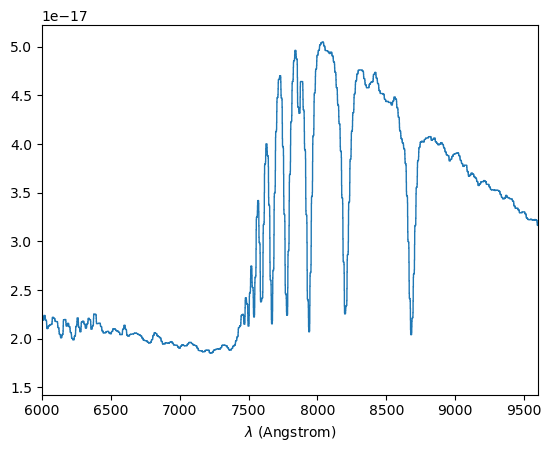

In [17]:
#example of mpdaf.obj functions
spe.plot()

and more as: `spe.truncate()`, `spe.get_step()`, `spe.get_start()`, `spe.filter()`, etc...